In [22]:
import numpy as np
import matplotlib.pyplot as plt
import iiiraven2 as ir2
from chainconsumer import ChainConsumer
import get_pkbkmst
import get_likelihood
from IPython.display import IFrame

from sklearn.covariance import LedoitWolf

ir2.set_plot_default()

## Settings

In [323]:
# Which method to use
method = 'bk'
# How many multiples of the MST should we use
multiples = 10

Getting Fiducial : |####################| 100% 


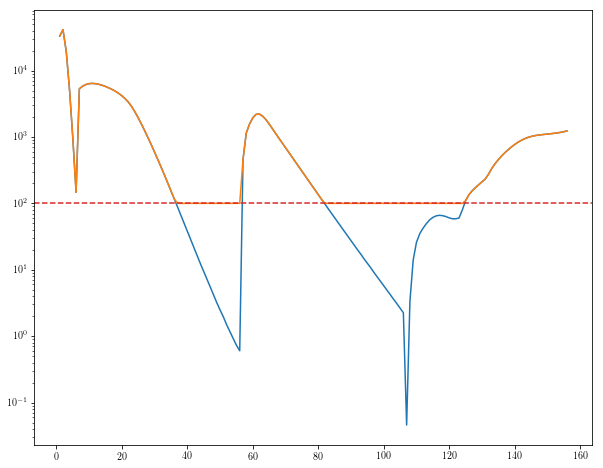

In [325]:
# Lets figure out basic things that we need to know.

which_method = 'mst'
condition_mst = [0, 1]
usefull = True
include_mult = True

fid_data_ = get_pkbkmst.get_fiducial(which_method, condition_mst, usefull=usefull,
                                    include_mult=include_mult, multiples=multiples)
fid_mean = np.mean(fid_data_, axis=0)
fid_mean2 = np.copy(fid_mean)

x = np.arange(1., len(fid_mean)+1., 1.)

count_min = 100.

plt.figure(figsize=(10, 8))
plt.plot(x, fid_mean)

condition_mst = np.where(fid_mean > count_min)[0]
condition_not_mst = np.where(fid_mean <= count_min)[0]

# check this works

fid_mean2[condition_not_mst] = count_min

plt.plot(x, fid_mean2)
plt.axhline(count_min, color='C3', linestyle='--')
plt.yscale('log')
plt.show()

## Get Data

In [326]:
which_method = method

# Get Parameters

as_grid, om_grid, mv_grid, s8_grid = get_pkbkmst.get_grid_params()
as_mock, om_mock, mv_mock, s8_mock = get_pkbkmst.get_mock_params()
as_fid, om_fid, mv_fid, s8_fid = get_pkbkmst.get_fiducial_params()

grid_data = get_pkbkmst.get_grid(which_method, condition_mst, usefull=usefull,
                                 include_mult=include_mult, multiples=multiples)
mock_data = get_pkbkmst.get_mock(which_method, condition_mst, usefull=usefull,
                                 include_mult=include_mult, multiples=multiples)
fid_data = get_pkbkmst.get_fiducial(which_method, condition_mst, usefull=usefull,
                                    include_mult=include_mult, multiples=multiples)

fid_mean = np.mean(fid_data, axis=0)
fid_std = np.std(fid_data, axis=0)

Getting Grid1 : |####################| 100% 
Getting Grid2 : |####################| 100% 
Getting Grid3 : |####################| 100% 
Getting Grid4 : |####################| 100% 
Getting Grid5 : |####################| 100% 
Getting Grid6 : |####################| 100% 
Getting Grid7 : |####################| 100% 
Getting Mock : |####################| 100% 
Getting Fiducial : |####################| 100% 


In [327]:
# Cut grid data to only the ones in this range.

as_min, as_max = 1., 3.5
om_min, om_max = 0.2, 0.5
mv_min, mv_max = 0., 0.5
s8_min, s8_max = s8_grid.min(), s8_grid.max()

condition = np.where((as_grid >= as_min) & (as_grid <= as_max) &
                     (om_grid >= om_min) & (om_grid <= om_max) &
                     (mv_grid >= mv_min) & (mv_grid <= mv_max))[0]

print 'Number of usable Grid Sims = ', len(condition)

as_grid = as_grid[condition]
om_grid = om_grid[condition]
mv_grid = mv_grid[condition]
s8_grid = s8_grid[condition]
grid_data = grid_data[condition]

Number of usable Grid Sims =  670


## Calculate Covariance and Precision Matrix

In [328]:
cov = np.cov(fid_data.T)
inv_cov = np.linalg.inv(cov)

lw = LedoitWolf(store_precision=True, assume_centered=False)
lw.fit(fid_data)
lw_cov_ = lw.covariance_
lw_prec_ = lw.precision_
cov, inv_cov = lw_cov_, lw_prec_

## Calculate Log-Likelihood

In [329]:
ln_probs = []

N, M = 1000., 3.
precision = inv_cov

for i in range(0, len(mock_data)):
    data = mock_data[i]
    ln_prob = []
    for j in range(0, len(grid_data)):
        model = grid_data[j]
        ln_prob_val = get_likelihood.get_lnP(data, model, precision, N, M)
        ln_prob.append(ln_prob_val)
    ln_probs.append(np.array(ln_prob))
ln_probs = np.array(ln_probs)

## Calculate Log-Likelihood Uncertainties

In [330]:
ln_probs_fid = []

N, M = 1000., 3.
precision = inv_cov

for i in range(0, len(fid_data)):
    data = fid_data[i]
    ln_prob = []
    for j in range(0, len(grid_data)):
        model = grid_data[j]
        ln_prob_val = get_likelihood.get_lnP(data, model, precision, N, M)
        ln_prob.append(ln_prob_val)
    ln_probs_fid.append(np.array(ln_prob))
ln_probs_fid = np.array(ln_probs_fid)

In [331]:
ln_probs_fid_mean = np.mean(ln_probs_fid, axis=0)
ln_probs_fid_std = np.std(ln_probs_fid, axis=0)

In [332]:
lnlike_fid_estimate = []

for i in range(0, len(fid_data)):
    fid_measured = fid_data[i]
    index = np.arange(len(fid_data))
    mask = np.where(index != 1)[0]
    fid_estimate = np.mean(fid_data[mask].reshape(333, int(M), len(fid_data[0])), axis=1)
    for j in range(0, len(fid_estimate)):
        lnlike_fid_estimate.append(get_likelihood.get_lnP(fid_measured, fid_estimate[j], inv_cov, N, M))
    ir2.progress_bar(i, len(fid_data))

lnlike_fid_estimate = np.array(lnlike_fid_estimate)

|####################| 100% 


In [333]:
plt.figure(figsize=(8, 6))
plt.hist(lnlike_fid_estimate, 100, normed=True, histtype='step')
plt.hist(ln_probs.flatten(), 100, normed=True, histtype='step')
plt.xlabel(r'$\ln\mathcal{L}$', fontsize=16)
plt.ylabel(r'$N$', fontsize=16)
plt.show()

### Choose Which Mock

In [334]:
mock = 1

Marginalise noise in likelihood with a sharp prior cut at the maximum likelihood value estimated from the fiducial models.

In [335]:
lnlike_grid_marginalise_noise = []

lnlike_x = np.linspace(ln_probs[mock-1].min() - 100., np.mean(lnlike_fid_estimate), 10000)

for i in range(0, len(ln_probs[mock-1])):
    weight = np.exp(-0.5*((lnlike_x - ln_probs[mock-1][i])**2.)/(np.std(lnlike_fid_estimate)**2.))
    lnlike_grid_marginalise_noise.append(np.sum(weight*lnlike_x)/np.sum(weight))

lnlike_grid_marginalise_noise = np.array(lnlike_grid_marginalise_noise)

Apply smoothing with condition that the reduced $\chi^{2}$ is roughly 1.

In [336]:
ngrid = 32
as_box = np.linspace(as_min, as_max, ngrid)
om_box = np.linspace(om_min, om_max, ngrid)
mv_box = np.linspace(mv_min, mv_max, ngrid)

as_box, om_box, mv_box = np.meshgrid(as_box, om_box, mv_box, indexing='ij')

as_box = as_box.flatten()
om_box = om_box.flatten()
mv_box = mv_box.flatten()

print np.shape(as_box), np.shape(om_box), np.shape(mv_box), 32**3

print as_box.min(), as_box.max()
print om_box.min(), om_box.max()
print mv_box.min(), mv_box.max()

(32768,) (32768,) (32768,) 32768
1.0 3.5
0.2 0.5
0.0 0.5


In [337]:
# Normalise boxes to unit box.

as_g = np.copy(as_grid)
om_g = np.copy(om_grid)
mv_g = np.copy(mv_grid)

as_g -= as_min
as_g /= as_max - as_min
om_g -= om_min
om_g /= om_max - om_min
mv_g -= mv_min
mv_g /= mv_max - mv_min

as_b = np.copy(as_box)
om_b = np.copy(om_box)
mv_b = np.copy(mv_box)

as_b -= as_min
as_b /= as_max - as_min
om_b -= om_min
om_b /= om_max - om_min
mv_b -= mv_min
mv_b /= mv_max - mv_min

print as_g.min(), as_g.max()
print om_g.min(), om_g.max()
print mv_g.min(), mv_g.max()

print as_b.min(), as_b.max()
print om_b.min(), om_b.max()
print mv_b.min(), mv_b.max()

0.00548696844993 0.99670781893
0.00520833333333 0.99609375
0.00256 0.995884773663
0.0 1.0
0.0 1.0
0.0 1.0


In [344]:
sig_r = 0.2#816
lnlike_grid_smooth = []

for i in range(0, len(lnlike_grid_marginalise_noise)):
    r = np.sqrt((as_g - as_g[i])**2. + (om_g - om_g[i])**2. + (mv_g - mv_g[i])**2.)
    weight = np.exp(-0.5*(r**2.)/(sig_r)**2.)
    if r.min() < 0.1:
        lnlike = np.sum(weight*lnlike_grid_marginalise_noise)/np.sum(weight)
    else:
        lnlike = lnlike_grid_marginalise_noise.min()
    lnlike_grid_smooth.append(lnlike)
    ir2.progress_bar(i, len(lnlike_grid_marginalise_noise))

lnlike_grid_smooth = np.array(lnlike_grid_smooth)

reduced_chi2 = np.sum((((lnlike_grid_marginalise_noise - lnlike_grid_smooth)**2.)/(ln_probs_fid_std**2.))/float(len(ln_probs_fid_std)))

print reduced_chi2

|####################| 100% 
0.419962686524


In [345]:
lnlike_box_smooth = []

for i in range(0, len(as_b)):
    r = np.sqrt((as_g - as_b[i])**2. + (om_g - om_b[i])**2. + (mv_g - mv_b[i])**2.)
    weight = np.exp(-0.5*(r**2.)/(sig_r)**2.)
    if r.min() < 0.2:
        lnlike = np.sum(weight*lnlike_grid_marginalise_noise)/np.sum(weight)
    else:
        lnlike = lnlike_grid_marginalise_noise.min()
    lnlike_box_smooth.append(lnlike)
    ir2.progress_bar(i, len(as_b))

lnlike_box_smooth = np.array(lnlike_box_smooth)

|####################| 100% 


In [346]:
as_true, om_true, mv_true = 2.13, 0.3175, 0.06
truth = [as_true, om_true, mv_true]
c = ChainConsumer()
c.add_chain([as_box, om_box, mv_box],
            parameters = ['as', 'om', 'mv'], 
            weights=np.exp(lnlike_box_smooth - lnlike_box_smooth.max()), grid=True)
c.configure(kde = [0.], sigmas = [1,2] )
fig = c.plotter.plot(figsize = (7,7), truth=truth)
plt.savefig('plots/test_pk_smooth.pdf')

In [347]:
IFrame("plots/test_pk_smooth.pdf", width=600, height=600)

## Cycle through each mock

In [322]:
for mock in range(1, 10+1):
    lnlike_grid_marginalise_noise = []

    lnlike_x = np.linspace(ln_probs[mock-1].min() - 100., np.mean(lnlike_fid_estimate), 10000)

    for i in range(0, len(ln_probs[mock-1])):
        weight = np.exp(-0.5*((lnlike_x - ln_probs[mock-1][i])**2.)/(np.std(lnlike_fid_estimate)**2.))
        lnlike_grid_marginalise_noise.append(np.sum(weight*lnlike_x)/np.sum(weight))

    lnlike_grid_marginalise_noise = np.array(lnlike_grid_marginalise_noise)
    
    sig_r = 0.05#816
    
    lnlike_grid_smooth = []

    for i in range(0, len(lnlike_grid_marginalise_noise)):
        r = np.sqrt((as_g - as_g[i])**2. + (om_g - om_g[i])**2. + (mv_g - mv_g[i])**2.)
        weight = np.exp(-0.5*(r**2.)/(sig_r)**2.)
        if r.min() < 0.1:
            lnlike = np.sum(weight*lnlike_grid_marginalise_noise)/np.sum(weight)
        else:
            lnlike = lnlike_grid_marginalise_noise.min()
        lnlike_grid_smooth.append(lnlike)
        ir2.progress_bar(i, len(lnlike_grid_marginalise_noise))

    lnlike_grid_smooth = np.array(lnlike_grid_smooth)

    reduced_chi2 = np.sum((((lnlike_grid_marginalise_noise - lnlike_grid_smooth)**2.)/(ln_probs_fid_std**2.))/float(len(ln_probs_fid_std)))

    print reduced_chi2
    
    lnlike_box_smooth = []

    for i in range(0, len(as_b)):
        r = np.sqrt((as_g - as_b[i])**2. + (om_g - om_b[i])**2. + (mv_g - mv_b[i])**2.)
        weight = np.exp(-0.5*(r**2.)/(sig_r)**2.)
        if r.min() < 0.2:
            lnlike = np.sum(weight*lnlike_grid_marginalise_noise)/np.sum(weight)
        else:
            lnlike = lnlike_grid_marginalise_noise.min()
        lnlike_box_smooth.append(lnlike)
        ir2.progress_bar(i, len(as_b))

    lnlike_box_smooth = np.array(lnlike_box_smooth)
    
    as_true, om_true, mv_true = 2.13, 0.3175, 0.06
    truth = [as_true, om_true, mv_true]
    c = ChainConsumer()
    c.add_chain([as_box, om_box, mv_box],
                parameters = ['as', 'om', 'mv'], 
                weights=np.exp(lnlike_box_smooth - lnlike_box_smooth.max()), grid=True)
    c.add_chain([as_box, om_box, mv_box],
                parameters = ['as', 'om', 'mv'], 
                weights=np.exp(lnlike_box_smooth - lnlike_box_smooth.max()), grid=True)
    c.configure(kde = [0., 1.], sigmas = [1,2] )
    fig = c.plotter.plot(figsize = (7,7), truth=truth)
    plt.savefig('plots/test_pk_mock_' + str(mock) + '.pdf')
    print mock, '/ 10'

|####################| 100% 
11.0844707594
|####################| 100% 


1 / 10
|####################| 100% 
11.3550483666
|####################| 100% 


2 / 10
|####################| 100% 
11.0791550701
|####################| 100% 


3 / 10
|####################| 100% 
11.3118057389
|####################| 100% 


4 / 10
|####################| 100% 
11.3837242594
|####################| 100% 


5 / 10
|####################| 100% 
11.4394589699
|####################| 100% 


6 / 10
|####################| 100% 
11.1332312201
|####################| 100% 


7 / 10
|####################| 100% 
11.0643675283
|####################| 100% 


8 / 10
|####################| 100% 
11.67431358
|####################| 100% 


9 / 10
|####################| 100% 
11.1576792718
|####################| 100% 


10 / 10


In [286]:
for mock in range(1, 10+1):
    IFrame('plots/test_pk_mock_' + str(mock) + '.pdf', width=600, height=600)